<a href="https://colab.research.google.com/github/kingsleyyeon/PrecisionMatEst/blob/main/cnn_slq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

β=0.01 | Ep  1 | loss 1.6015 | acc 0.866
β=0.01 | Ep  2 | loss 1.2399 | acc 0.890
β=0.01 | Ep  3 | loss 1.2432 | acc 0.891
β=0.01 | Ep  4 | loss 1.2448 | acc 0.896
β=0.01 | Ep  5 | loss 1.2485 | acc 0.899
β=0.01 | Ep  6 | loss 1.2530 | acc 0.903
β=0.01 | Ep  7 | loss 1.2608 | acc 0.899
β=0.01 | Ep  8 | loss 1.2585 | acc 0.904
β=0.01 | Ep  9 | loss 1.2595 | acc 0.898
β=0.01 | Ep 10 | loss 1.2617 | acc 0.902
β=0.01 | Ep 11 | loss 1.2598 | acc 0.901
β=0.01 | Ep 12 | loss 1.2668 | acc 0.898
β=0.01 | Ep 13 | loss 1.2750 | acc 0.900
β=0.01 | Ep 14 | loss 1.2675 | acc 0.900
β=0.01 | Ep 15 | loss 1.2799 | acc 0.898
β=0.00 | Ep  1 | loss 0.9167 | acc 0.849
β=0.00 | Ep  2 | loss 0.4761 | acc 0.871
β=0.00 | Ep  3 | loss 0.4079 | acc 0.880
β=0.00 | Ep  4 | loss 0.3715 | acc 0.881
β=0.00 | Ep  5 | loss 0.3452 | acc 0.886
β=0.00 | Ep  6 | loss 0.3270 | acc 0.890
β=0.00 | Ep  7 | loss 0.3104 | acc 0.892
β=0.00 | Ep  8 | loss 0.2982 | acc 0.891
β=0.00 | Ep  9 | loss 0.2867 | acc 0.891
β=0.00 | Ep 10 |

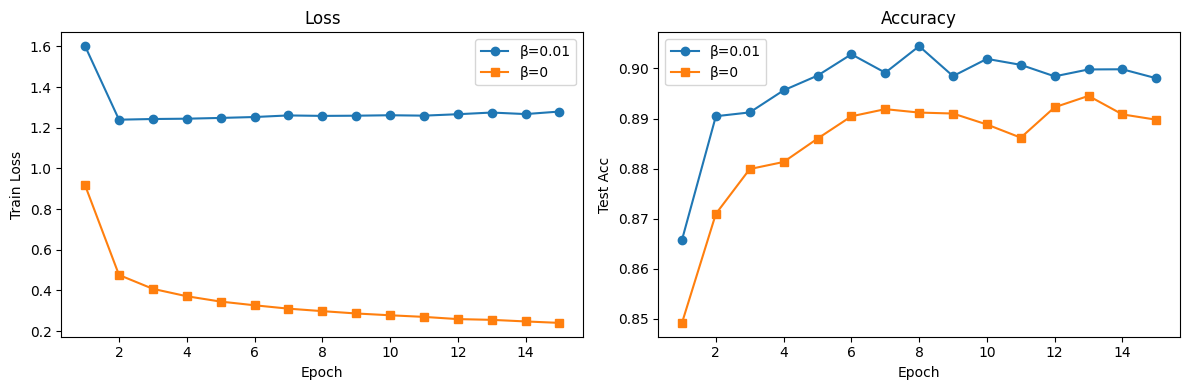

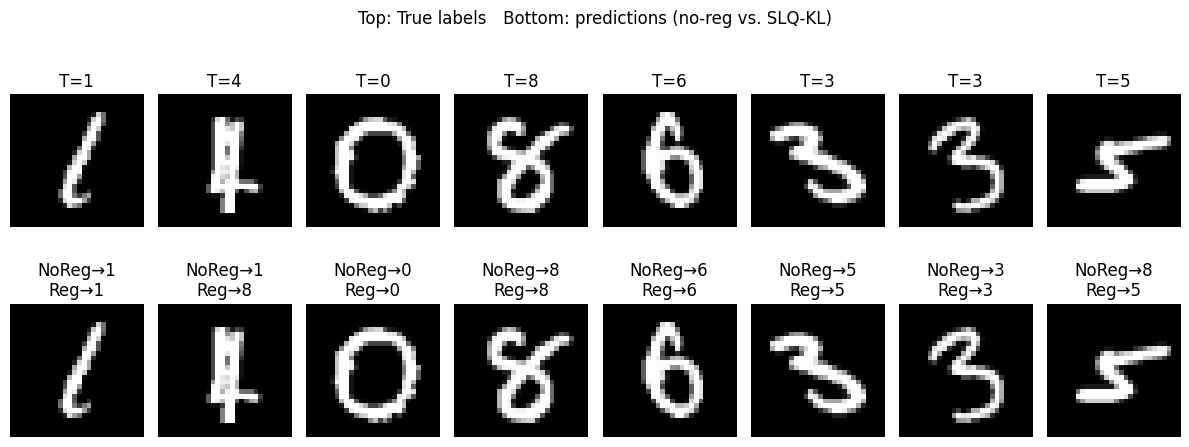

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# 1) Load & split MNIST, but only 10% for training
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, data_home="data")
X = X.astype(np.float32) / 255.0
y = y.astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.10, test_size=0.90, random_state=0, stratify=y
)
train_X = torch.tensor(X_train)
train_y = torch.tensor(y_train)
test_X  = torch.tensor(X_test)
test_y  = torch.tensor(y_test)

# 2) A tiny MLP
class Net(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=8, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        h = self.relu(self.fc1(x))
        return self.fc2(h), h

# 3) SLQ‐KL estimator (same as before)
def get_effective_dimension(L, tol=1e-12):
    return np.sum(np.abs(np.diag(L)) > tol)

def block_lanczos(A, V, num_steps):
    # stub: just return A itself as "tridiagonal"
    return A

def unified_kl_divergence_block_slq(Sigma, L, q, t, s, k, eps=1e-12):
    r_eff = get_effective_dimension(L, tol=eps)
    idx   = np.arange(r_eff)
    def f(x):
        x = np.maximum(x, eps)
        return x - np.log(x) - 1.0
    estimates = []
    for _ in range(t):
        S = np.random.choice(idx, size=s, replace=False)
        L_S   = L[np.ix_(S,S)]
        Σ_S   = Sigma[np.ix_(S,S)]
        A_S   = L_S.T @ (Σ_S @ L_S)
        probes = []
        for _ in range(q):
            Z, _ = np.linalg.qr(np.random.choice([-1,1], size=(s,s)).astype(float))
            T    = block_lanczos(A_S, Z, k)
            eigs, U = np.linalg.eigh(T)
            w = np.sum(U[:s,:]**2, axis=0)
            probes.append(np.sum(w * f(eigs)))
        estimates.append(np.mean(probes))
    trace_est = (r_eff/(t*s)) * np.sum(estimates)
    return 0.5 * trace_est

# 4) Training loop
def run_experiment(beta, hidden_dim=8, batch_size=4, epochs=15):
    model = Net(hidden_dim=hidden_dim)
    opt   = optim.Adam(model.parameters(), lr=1e-3)
    ce    = nn.CrossEntropyLoss()
    train_losses, test_accs = [], []
    for ep in range(epochs):
        model.train()
        perm = torch.randperm(len(train_X))
        total_loss = 0.0
        for i in range(0, len(perm), batch_size):
            idx = perm[i:i+batch_size]
            x, yb = train_X[idx], train_y[idx]
            opt.zero_grad()
            logits, h = model(x)
            loss_ce = ce(logits, yb)
            # compute SLQ‐KL on the small batch
            if beta>0:
                H = h.detach().numpy()
                Hc = H - H.mean(0, keepdims=True)
                Σ = (Hc.T @ Hc)/(H.shape[0]-1)
                L = np.eye(Σ.shape[0])
                kl = unified_kl_divergence_block_slq(Σ, L, q=2, t=3, s=min(Σ.shape[0],hidden_dim), k=hidden_dim)
            else:
                kl = 0.0
            loss = loss_ce + beta*kl
            loss.backward(); opt.step()
            total_loss += loss.item()
        train_losses.append(total_loss/(len(perm)/batch_size))

        # eval
        model.eval()
        with torch.no_grad():
            logits,_ = model(test_X)
            pred = logits.argmax(1)
            acc  = (pred==test_y).float().mean().item()
        test_accs.append(acc)
        print(f"β={beta:.2f} | Ep {ep+1:2d} | loss {train_losses[-1]:.4f} | acc {acc:.3f}")
    return model, train_losses, test_accs

# 5) Run both: with and without regularizer
model_reg,  loss_reg,  acc_reg  = run_experiment(beta=0.01)
model_noreg,loss_noreg,acc_noreg= run_experiment(beta=0.0)

# 6) Plot training curves
ep = np.arange(1,len(loss_reg)+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ep, loss_reg, '-o', label='β=0.01')
plt.plot(ep, loss_noreg, '-s', label='β=0')
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.legend()
plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(ep, acc_reg, '-o', label='β=0.01')
plt.plot(ep, acc_noreg, '-s', label='β=0')
plt.xlabel("Epoch"); plt.ylabel("Test Acc"); plt.legend()
plt.title("Accuracy")
plt.tight_layout()
plt.show()

# 7) Visualize a handful of test digits & predictions
n_show = 8
imgs    = test_X[:n_show].numpy().reshape(-1,28,28)
true_lb = test_y[:n_show].numpy()
with torch.no_grad():
    pr_reg   = model_reg(test_X[:n_show])[0].argmax(1).numpy()
    pr_noreg = model_noreg(test_X[:n_show])[0].argmax(1).numpy()

plt.figure(figsize=(12,5))
for i in range(n_show):
    ax = plt.subplot(2,n_show,i+1)
    ax.imshow(imgs[i], cmap='gray'); ax.axis('off')
    ax.set_title(f"T={true_lb[i]}")
for i in range(n_show):
    ax = plt.subplot(2,n_show,n_show+i+1)
    ax.imshow(imgs[i], cmap='gray'); ax.axis('off')
    ax.set_title(f"NoReg→{pr_noreg[i]}\nReg→{pr_reg[i]}")
plt.suptitle("Top: True labels Bottom: predictions (no‐reg vs. SLQ‐KL)")
plt.tight_layout()
plt.show()


β=0.01 | Ep  1 | loss 1.3592 | acc 0.897
β=0.01 | Ep  2 | loss 1.2619 | acc 0.909
β=0.01 | Ep  3 | loss 1.2784 | acc 0.911
β=0.01 | Ep  4 | loss 1.2949 | acc 0.915
β=0.01 | Ep  5 | loss 1.3174 | acc 0.905
β=0.01 | Ep  6 | loss 1.3354 | acc 0.918
β=0.01 | Ep  7 | loss 1.3572 | acc 0.921
β=0.01 | Ep  8 | loss 1.3712 | acc 0.914
β=0.01 | Ep  9 | loss 1.3958 | acc 0.918
β=0.01 | Ep 10 | loss 1.3930 | acc 0.919
β=0.01 | Ep 11 | loss 1.4232 | acc 0.920
β=0.01 | Ep 12 | loss 1.4255 | acc 0.921
β=0.01 | Ep 13 | loss 1.4433 | acc 0.918
β=0.01 | Ep 14 | loss 1.4413 | acc 0.918
β=0.01 | Ep 15 | loss 1.4448 | acc 0.910
β=0.00 | Ep  1 | loss 0.6415 | acc 0.884
β=0.00 | Ep  2 | loss 0.3761 | acc 0.891
β=0.00 | Ep  3 | loss 0.3346 | acc 0.903
β=0.00 | Ep  4 | loss 0.3136 | acc 0.907
β=0.00 | Ep  5 | loss 0.2984 | acc 0.911
β=0.00 | Ep  6 | loss 0.2871 | acc 0.905
β=0.00 | Ep  7 | loss 0.2816 | acc 0.910
β=0.00 | Ep  8 | loss 0.2732 | acc 0.913
β=0.00 | Ep  9 | loss 0.2692 | acc 0.912
β=0.00 | Ep 10 |

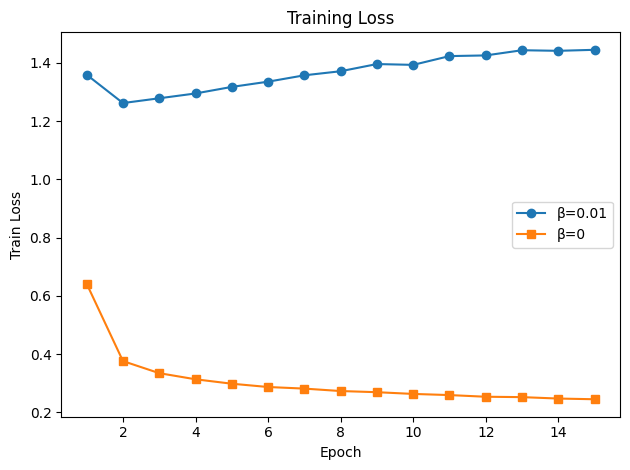

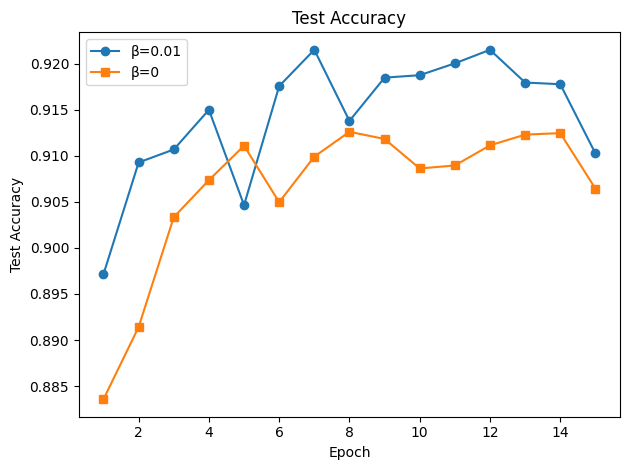

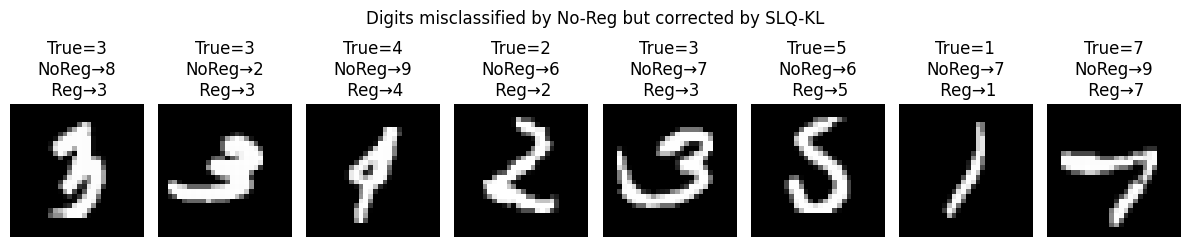

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Set a random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# 1) Load & split MNIST, now 30% for training
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, data_home="data")
X = X.astype(np.float32) / 255.0
y = y.astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.30, test_size=0.70, random_state=0, stratify=y
)
train_X = torch.tensor(X_train)
train_y = torch.tensor(y_train)
test_X  = torch.tensor(X_test)
test_y  = torch.tensor(y_test)

# 2) Tiny MLP
class Net(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=8, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        h = self.relu(self.fc1(x))
        return self.fc2(h), h

# 3) SLQ-KL estimator
def get_effective_dimension(L, tol=1e-12):
    return np.sum(np.abs(np.diag(L)) > tol)

def block_lanczos(A, V, num_steps):
    return A  # Stub (not used meaningfully here)

def unified_kl_divergence_block_slq(Sigma, L, q, t, s, k, eps=1e-12):
    r_eff = get_effective_dimension(L, tol=eps)
    idx = np.arange(r_eff)
    def f(x):
        x = np.maximum(x, eps)
        return x - np.log(x) - 1.0
    estimates = []
    for _ in range(t):
        S = np.random.choice(idx, size=s, replace=False)
        L_S = L[np.ix_(S, S)]
        Σ_S = Sigma[np.ix_(S, S)]
        A_S = L_S.T @ (Σ_S @ L_S)
        probes = []
        for _ in range(q):
            Z, _ = np.linalg.qr(np.random.choice([-1,1], size=(s,s)).astype(float))
            T = block_lanczos(A_S, Z, k)
            eigs, U = np.linalg.eigh(T)
            w = np.sum(U[:s, :]**2, axis=0)
            probes.append(np.sum(w * f(eigs)))
        estimates.append(np.mean(probes))
    trace_est = (r_eff / (t*s)) * np.sum(estimates)
    return 0.5 * trace_est

# 4) Training loop
def run_experiment(beta, hidden_dim=8, batch_size=4, epochs=15):
    model = Net(hidden_dim=hidden_dim)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    ce = nn.CrossEntropyLoss()
    train_losses, test_accs = [], []
    for ep in range(epochs):
        model.train()
        perm = torch.randperm(len(train_X))
        total_loss = 0.0
        for i in range(0, len(perm), batch_size):
            idx = perm[i:i+batch_size]
            x, yb = train_X[idx], train_y[idx]
            opt.zero_grad()
            logits, h = model(x)
            loss_ce = ce(logits, yb)
            if beta > 0:
                H = h.detach().numpy()
                Hc = H - H.mean(0, keepdims=True)
                Σ = (Hc.T @ Hc)/(H.shape[0]-1)
                L = np.eye(Σ.shape[0])
                kl = unified_kl_divergence_block_slq(Σ, L, q=2, t=3, s=min(Σ.shape[0], hidden_dim), k=hidden_dim)
            else:
                kl = 0.0
            loss = loss_ce + beta * kl
            loss.backward(); opt.step()
            total_loss += loss.item()
        train_losses.append(total_loss / (len(perm) / batch_size))
        model.eval()
        with torch.no_grad():
            logits, _ = model(test_X)
            pred = logits.argmax(1)
            acc = (pred == test_y).float().mean().item()
        test_accs.append(acc)
        print(f"β={beta:.2f} | Ep {ep+1:2d} | loss {train_losses[-1]:.4f} | acc {acc:.3f}")
    return model, train_losses, test_accs

# 5) Run experiments: with and without SLQ-KL regularization
model_reg,  loss_reg,  acc_reg = run_experiment(beta=0.01)
model_noreg,loss_noreg,acc_noreg = run_experiment(beta=0.0)

# 6) Plot Loss (separate figure)
epochs = np.arange(1, len(loss_reg)+1)

plt.plot(epochs, loss_reg, '-o', label='β=0.01')
plt.plot(epochs, loss_noreg, '-s', label='β=0')
plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.legend()
plt.title("Training Loss")
plt.tight_layout()
plt.show()

# 7) Plot Accuracy (separate figure)
plt.plot(epochs, acc_reg, '-o', label='β=0.01')
plt.plot(epochs, acc_noreg, '-s', label='β=0')
plt.xlabel("Epoch"); plt.ylabel("Test Accuracy"); plt.legend()
plt.title("Test Accuracy")
plt.savefig('accuracy_slq.png', dpi=300)
plt.tight_layout()
plt.show()

# 8) Visualize digits where NoReg wrong but Reg correct
with torch.no_grad():
    pr_reg   = model_reg(test_X)[0].argmax(1).numpy()
    pr_noreg = model_noreg(test_X)[0].argmax(1).numpy()

true_lb = test_y.numpy()

# Find mismatch (correct with Reg, wrong with NoReg)
mask = (pr_reg == true_lb) & (pr_noreg != true_lb)
indices = np.where(mask)[0]

# Randomly choose up to 8 examples
np.random.seed(0)  # Fix seed again for sampling
n_show = min(8, len(indices))
chosen = np.random.choice(indices, size=n_show, replace=False)

# Extract samples
imgs = test_X[chosen].numpy().reshape(-1,28,28)
true_vals = true_lb[chosen]
noreg_preds = pr_noreg[chosen]
reg_preds = pr_reg[chosen]

# Plot
plt.figure(figsize=(12,3))
for i in range(n_show):
    ax = plt.subplot(1, n_show, i+1)
    ax.imshow(imgs[i], cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True={true_vals[i]}\n"
        f"NoReg→{noreg_preds[i]}\n"
        f" Reg→{reg_preds[i]}"
    )
plt.suptitle("Digits misclassified by No-Reg but corrected by SLQ-KL")
plt.tight_layout()
plt.savefig('labels_pred.png', dpi=300)
plt.show()
